# Full MICADO focal plane spectroscopic trace simulations

This example is a biggun'. And it will take **upwards of half an hour** to compute depending on your hardware.
What we are doing here is using ScopeSim to project the full spectroscopic trace pattern of two point sources (a binary star system) after they have passed through the full optical system (atmosphere --> detector) onto the MICADO detector array.

This type of simulation is directed towards the team developing the data reduction pipeline. 
That said, there may be other users who would like to have a full readout of the MICADO detectors in this configuration.
It should be noted that ScopeSim **does not** provide any kind of reduction functionality. 
It is therefore up to the user to reduce and analyse their own spectra derived from these simulations.
A more user-friendly spectroscopy option is provided with the ``MICADO_Sci`` package (see the previous example notebook)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%config Completer.use_jedi = False

### Set up source

A simple object, the binary star system, can be created with the ``stars`` function in the ``scopesim_templates.basic.stars`` submodule. 
Our binary system consists of two stars with similar spectral types seperated by 200 mas. 
Each star is located 0.1 arcsec either side of the centre of the field of view.
The stars are both 18 ABmags in the Ks filter.

We redshift one of stars to induce a shift in the spectrum, that we will hopefully recover from the final simulated image.
This is visible in the right plot below.

In [2]:
stars = sim_tp.stellar.stars(
    filter_name="Ks",
    amplitudes=[18,18]*u.ABmag,
    spec_types=["A0V", "A1V"],
    x=[-0.1, 0.1],
    y=[0, 0],
)
stars.spectra[1].z = 0.01

ERROR - File cannot be found: Ks
ERROR - File cannot be found: Ks


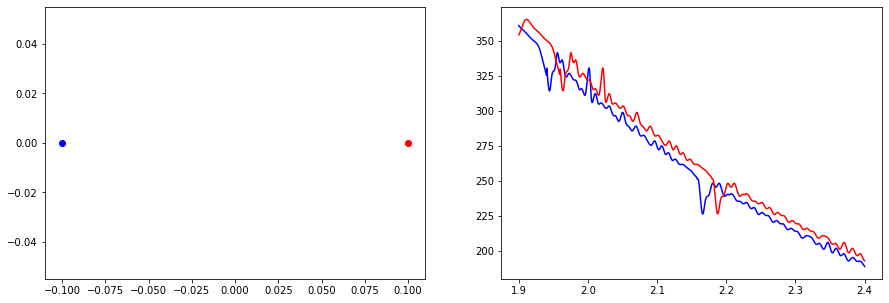

In [3]:
plt.figure(figsize=(15,5))
wave = np.linspace(1.9, 2.4, 1001) * u.um
for i, c in zip([0, 1], "br"):
    plt.subplot(121)
    plt.scatter(stars.fields[0]["x"][i], stars.fields[0]["y"][i], c=c)
    plt.subplot(122)
    plt.plot(wave, stars.spectra[i](wave), c=c)

### Set up MICADO in SPEC mode, 3 arcsec slit and HK filter

There are three spectroscopy modes available in the ``MICADO`` package, each uses a different slit:

- ``SPEC_3000x20``: Short and narrow, with a 20mas slit that is 3 arcsec long
- ``SPEC_3000x50``: Short and fat, with a 50mas slit that is 3 arcsec long
- ``SPEC_15000x50``: Long and fat, with a 50mas slit that is 15 arcsec long

For the sake of this example we will use the short and fat slit, or 3 arcsec by 50 mas.

The default filter in the spectroscopy modes is the ``Spec_HK`` filter. The other spectroscopy specific filter is names ``Spec_IJ``. It is however possible to use any other filter in any of the three wheels. Different filters can be selected using the bang-string keywords: ``"!OBS.filter_name_fw1"`` for filter wheel 1, ``"!OBS.filter_name_fw2"`` for filter wheel 2, and ``"!OBS.filter_name_pupil"`` for the pupil wheel. 

In [4]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC_3000x50"])
cmd["!OBS.filter_name_fw1"] = "Spec_HK"
cmd["!OBS.filter_name_fw2"] = "open"
cmd["!OBS.filter_name_pupil"] = "open"

cmd["!OBS.dit"] = 600     # [s]

Unfortunately the only way to see which filters are available is to either look in the instrument package folder in the working directory, or by initialising the ``OpticalTrain`` object and then looking at the contents of each filter wheel. This is done with the following command:
```
micado["filter_wheel_1"].data["names"]
```
for each of ``filter_wheel_1``, ``filter_wheel_2``, and ``pupil_wheel``.

Once we've set which filter we want to use, we can generate the optical model of MICADO.

The purpose of this example is to show the trace pattern of MICADO's long slit spectrograph on the focal plane. 
We therefore need to turn off the detector window and turn on the full detector array.
This is done be setting the ``include`` property of the relevant ``Effect`` objects to ``True`` or ``False``.

To find the name of any ``Effect`` in the optical model, call:
```
micado.effects
```

In [5]:
micado = sim.OpticalTrain(cmd)

# Switch these two commands to run the full notebook.
# micado["full_detector_array"].include = True
# micado["detector_window"].include = False
micado["full_detector_array"].include = False
micado["detector_window"].include = True

Finally we are set and can simulate the observation of out binary star system

**WARNING: over 25000 spectral slices must be created and observed to run this simulation.** Please expect this to take on the order of 30 minutes to complete (hardware dependent). The best strategy would be to create a script with the commands from this notebook and execute it in the background. Also, save as much of the simulation to disk as possible to avoid wasting execution time.

In [6]:
micado.observe(stars)

INFO - emission not found in either '.meta' or '.table': [ELT]
INFO - emission not found in either '.meta' or '.table': [I00_EntrWin]
INFO - emission not found in either '.meta' or '.table': [I09_SCAO_PO]
INFO - emission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emissivity not found in either '.meta' or '.table': [I01_Fold1]
INFO - transmission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emissivity not found in either '.meta' or '.table': [I02_Coli1]
INFO - transmission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emissivity not found in either '.meta' or '.table': [I03_Coli2]
INFO - transmission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emission not found in either '.meta' or '.table': [I04_Coli3]
INFO - emissivity not found in either '.meta' or '.table': [I04_Coli3]
INFO - transmiss

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7057.77705817  7085.38850061  7165.69172596
  7185.16584771  7275.25642823  7286.34827217  7386.4963943
  7388.95556048  7493.00777774  7499.43723926  7598.52527164
  7614.10496985  7705.52867638  7730.52599046  7814.03891675
  7848.7271092   7924.07721221  7968.73554409  8035.66508101
  8090.57892931  8148.82434446  8214.28532159  8263.57713113
  8339.88320663  8379.94588121  8467.40150569  8497.95335092
  8596.86958225  8617.62261692  8728.31724875  8738.97708082
  8861.77477348  8862.0404738   8986.83686122  8997.27288752
  9113.39064734  9134.84279184  9241.72658005  9274.5161645
  9371.86975579  9416.32516789  9503.84562437  9560.30245619
  9600.          9610.          9637.67999401  9706.48118286
  9773.39903636  9854.89500829  9911.02929163 10005.57810754
 10050.59767375 10158.5651782  10192.13147568 10313.8914484
 10335.65837471 10471.59268494 10481.2064379  10

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7057.77705817  7165.69172596  7275.25642823
  7386.4963943   7499.43723926  7614.10496985  7730.52599046
  7848.7271092   7968.73554409  8090.57892931  8214.28532159
  8339.88320663  8467.40150569  8596.86958225  8728.31724875
  8861.77477348  8997.27288752  9134.84279184  9274.5161645
  9416.32516789  9560.30245619  9706.48118286  9854.89500829
 10005.57810754 10158.5651782  10313.8914484  10471.59268494
 10631.70520145 10794.26586686 10959.31211377 11126.88194719
 11297.01395319 11469.74730786 11645.12178627 11823.17777169
 12003.95626482 12187.49889329 12373.84792123 12563.04625899
 12755.13747302 12950.16579591 13148.17613658 13349.21409061
 13553.32595075 13760.55871758 13970.9601103  14184.57857778
 14401.46330966 14621.6642477  14845.23209729 15072.21833911
 15302.67524097 15536.6558699  15774.2141043  16015.4046464
 16260.28303483 16508.90565741 16761.32976416 1

INFO - Waverange does not overlap with Spectrum waveset: [14459.999999999996, 14499.999999999996] <> [ 7000.          7070.52282746  7169.90922239  7180.
  7270.69263643  7372.89270669  7476.52934633  7581.62274839
  7688.19338978  7796.26203522  7830.          7905.84974132
  8016.97786067  8129.668046    8243.9422544   8359.82275159
  8390.          8477.33211629  8596.49324457  8717.32935435
  8839.86398992  8964.1210265   8980.          9090.12467493
  9217.89948634  9347.470357    9478.86253311  9490.
  9612.10161573  9747.2135658   9884.22470919 10000.
 10023.16174178 10164.05173473 10306.92213971 10451.80079427
 10580.         10598.71592725 10747.6961643  10898.77053343
 11051.96847068 11207.31982587 11360.         11364.8548684
 11524.60429313 11686.59922641 11850.8712321  11990.
 12017.45231772 12186.37494073 12357.67201482 12531.37691631
 12707.52349071 12880.         12886.14605922 13067.27942554
 13250.95888254 13437.22021919 13626.09972755 13817.63420978
 13830.         1

We can check that the ``observe`` command ran successfully by looking inside the ``MICADO`` optical model.
The resulting normalised flux map in units of ph s-1 pixel-1 can be found in the first entry of the ``image_planes`` attribute of the optical model, in the form of a ``fits.HDUList`` object.
If the size of the data image is ~12000x12000, then the simulation has been run successfully.

**Note:** this image is the "perfect" image of the source. It contains all contaminating flux (atmosphere, telescope greybody emission, etc) but has not had the poisson noise effects and detector read noise effects applied to it.
It is still however useful to keep this image as a sanity check - i.e. that the expected flux levels are indeed seen at the detector plane.

We can save this intermediate image using the standard ``fits.HDUList`` functionality, i.e. the ``writeto`` method:

In [7]:
print(micado.image_planes[0].data.shape)
micado.image_planes[0].hdu.writeto("micado_spec_focal_plane_flux_map.fits", overwrite=True)

(1025, 1025)


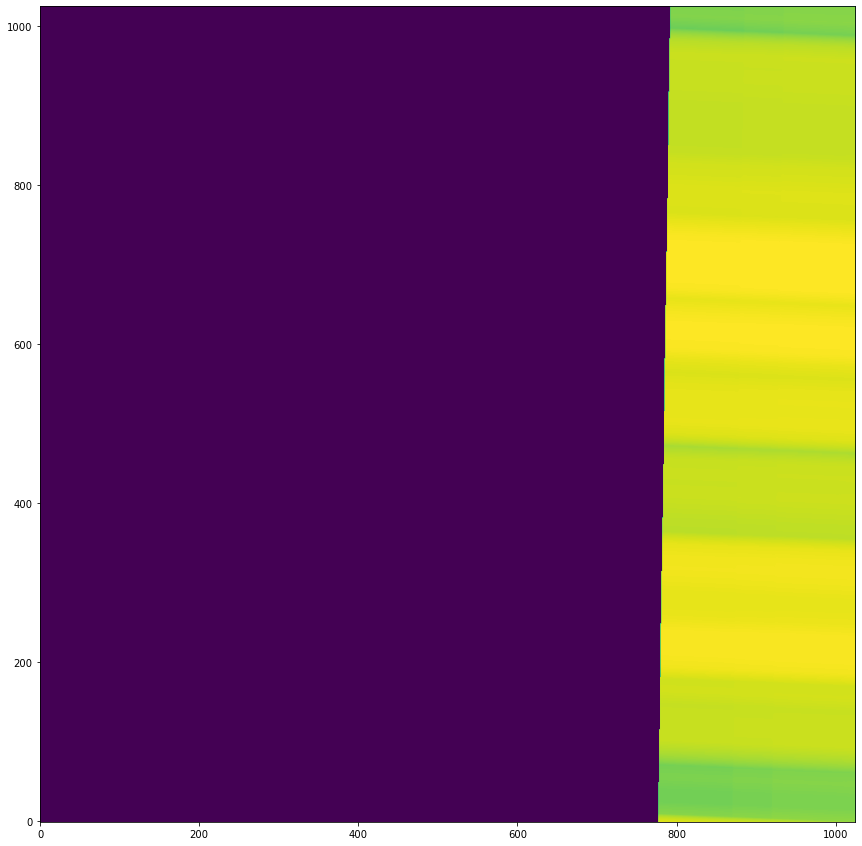

In [8]:
im = micado.image_planes[0].data
im[im<1e-7] = 1e-7

plt.figure(figsize=(15, 15))
plt.imshow(im, origin="lower", norm=LogNorm())

The above image shows the flux distribution of the three spectral traces for the ``Spec_HK`` filter over the full focal plane of MICADO.
To convert these into individual detector read out frames, we still need to call ``micado.readout``.
The final output file will be a FITS file containing 10 ``HDU``s.
The Primary HDU (index 0) contains meta data about the simulation.
HDUs 1-9 contain the raw images from each detector in the MICADO detector array, including all known detector characterists (RON, ACN, Dark current, linearity effects, dead pixels, etc)

Don't forget to save the output image to disk.

In [9]:
hdus = micado.readout(filename="micado_spec_detector_readout.fits", overwrite=True)

Becasue the MICADO detector array numbering scheme does not follow the matplotlib LRTB scheme, we cannot simply plot all the detector images in a standard ``for`` loop.

We can visualise the detector numbering scheme by calling the ``plot`` function of the ``full_detector_array`` ``Effect`` object:

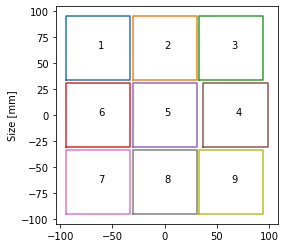

In [10]:
micado["full_detector_array"].plot()
plt.show()

Below we have the raw output images from the 9 MICADO detectors. Note the slight shift in the 6th detector.
The right 3 detectors recieve no flux projected through the slit when the Spec_HK filter is used.
The patterns visible on these detectors are due to the noise characteristics.
They are identical because ScopeSim resets the numpy random seed for each operation. 
This reset operation could be turned off (``micado.cmds[!"SIM.random.seed"] = None``) in order to get more realistic noise proerties.


In [11]:
# This only works if you simulate the full detector, see above.
if False:
    plt.figure(figsize=(20, 20))
    for hdu_i, plot_i in zip([1,2,3,6,5,4,7,8,9], range(1, 10)):
        plt.subplot(3,3,plot_i)
        plt.imshow(hdus[0][hdu_i].data, origin="lower", norm=LogNorm())   